In [1]:
ENV["GKS_ENCODING"]="utf8"

using Rocket, ReactiveMP, GraphPPL
using Distributions, Plots
using Random, LinearAlgebra, BenchmarkTools

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1342


In [2]:
Random.seed!(125)

L         = 50.0
nmixtures = 6
n_samples = 500

probvec = ones(nmixtures)
probvec = probvec ./ sum(probvec)

switch = Categorical(probvec)

println("Switch distribution: ", Distributions.params(switch))

gaussians = map(1:nmixtures) do index
    angle      = 2π / nmixtures * (index - 1)
    basis_v    = L * [ 1.0, 0.0 ]
    rotationm  = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
    mean       = rotationm * basis_v 
    covariance = Matrix(Hermitian(rotationm * [ 10.0 0.0; 0.0 20.0 ] * transpose(rotationm)))
    return MvNormal(mean, covariance)
end

z = rand(switch, n_samples)
y = Vector{Vector{Float64}}(undef, n_samples)

for i in 1:n_samples
    y[i] = rand(gaussians[z[i]])
end

Switch distribution: ([0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666],)


In [3]:
sdim(n) = (a) -> map(d -> d[n], a)

sdim (generic function with 1 method)

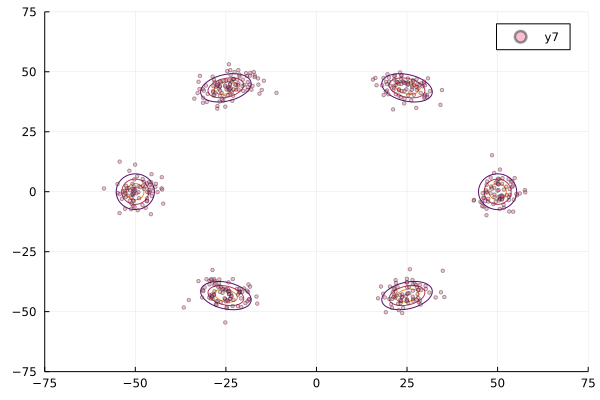

In [4]:
p = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

for (index, gaussian) in enumerate(gaussians)
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 3, colorbar = false)
end

p = scatter!(y |> sdim(1), y |> sdim(2), ms = 2, alpha = 0.4)

plot(p, size = (600, 400))

In [5]:
@model function gaussian_mixture_model(rng, nmixtures, n)
    
    z = randomvar(n)
    m = randomvar(nmixtures)
    w = randomvar(nmixtures)
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        # Assume we now only approximate location of cluters's mean
        approximate_angle_prior = ((2π + + rand(rng)) / nmixtures) * (i - 1)
        approximate_basis_v  = L / 2 * (basis_v .+ rand(rng, 2))
        approximate_rotation = [ cos(approximate_angle_prior) -sin(approximate_angle_prior); sin(approximate_angle_prior) cos(approximate_angle_prior) ]
        mean_mean_prior     = approximate_rotation * approximate_basis_v
        mean_mean_cov       = [ 1e6 0.0; 0.0 1e6 ]
        
        m[i] ~ MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov)
        w[i] ~ Wishart(3, [ 1e2 0.0; 0.0 1e2 ])
    end
    
    s ~ Dirichlet(ones(nmixtures))

    y = datavar(Vector{Float64}, n)
    
    means = tuple(m...)
    precs = tuple(w...)
    
    for i in 1:n
        z[i] ~ Categorical(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], means, precs) where { q = MeanField() }
    end
    
    return s, z, m, w, y
end

gaussian_mixture_model (generic function with 1 method)

In [6]:
function inference(rng, nmixtures, data, viters)
    n = length(data)
    
    model, (s, z, m, w, y) = gaussian_mixture_model(rng, nmixtures, n)
    
    means_estimates  = keep(Vector{Marginal})
    precs_estimates  = keep(Vector{Marginal})
    switch_estimates = keep(Marginal)
    fe_values        = keep(Float64)

    s_sub = subscribe!(getmarginal(s), switch_estimates)
    m_sub = subscribe!(getmarginals(m), means_estimates)
    p_sub = subscribe!(getmarginals(w), precs_estimates)
    f_sub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe_values)
    
    setmarginal!(s, vague(Dirichlet, nmixtures))
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        # Assume we now only approximate location of cluters's mean
        approximate_angle_prior = ((2π + + rand(rng)) / nmixtures) * (i - 1)
        approximate_basis_v  = L / 2 * (basis_v .+ rand(rng, 2))
        approximate_rotation = [ cos(approximate_angle_prior) -sin(approximate_angle_prior); sin(approximate_angle_prior) cos(approximate_angle_prior) ]
        mean_mean_prior     = approximate_rotation * approximate_basis_v
        mean_mean_cov       = [ 1e6 0.0; 0.0 1e6 ]
        
        setmarginal!(m[i], MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov))
        setmarginal!(w[i], Wishart(3, [ 1e2 0.0; 0.0 1e2 ]))
    end
    
    for i in 1:viters
        update!(y, data)
    end
    
    unsubscribe!((s_sub, m_sub, p_sub, f_sub))
    
    return switch_estimates, means_estimates, precs_estimates, fe_values
end

inference (generic function with 1 method)

In [7]:
rng = MersenneTwister(42)
s, m, w, fe = inference(rng, nmixtures, y, 25);

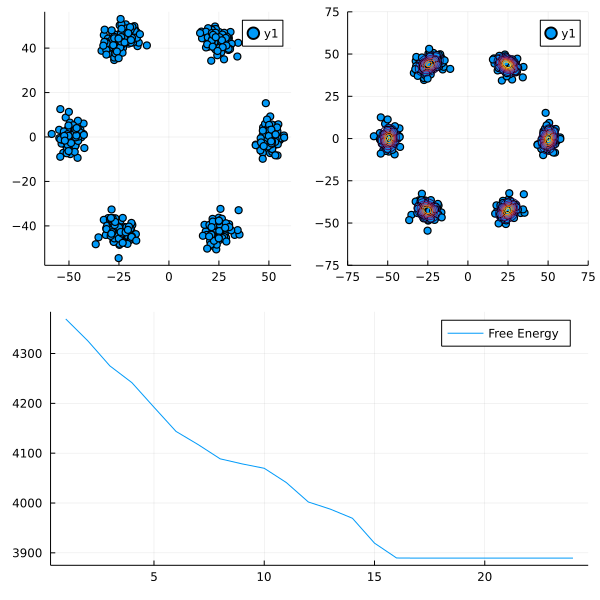

In [8]:
pe = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

rp = scatter(y |> sdim(1), y |> sdim(2))

pe = scatter!(pe, y |> sdim(1), y |> sdim(2))

e_means = mean.(m[end])
e_precs = mean.(w[end])

for (e_m, e_w) in zip(e_means, e_precs)
    gaussian = MvNormal(e_m, Matrix(Hermitian(inv(e_w))))
    pe = contour!(pe, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 7, colorbar = false)
end

pfe = plot(fe[2:end], label = "Free Energy")

plot(rp, pe, pfe, size = (600, 600), layout = @layout([ a b; c ]))

In [9]:
@benchmark inference(MersenneTwister(42), $nmixtures, $y, 25)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.467 s …   2.538 s  ┊ GC (min … max): 16.39% … 15.07%
 Time  (median):     2.502 s              ┊ GC (median):    15.72%
 Time  (mean ± σ):   2.502 s ± 50.194 ms  ┊ GC (mean ± σ):  15.72% ±  0.94%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.47 s         Histogram: frequency by time        2.54 s <

 Memory estimate: 1.27 GiB, allocs estimate: 15350422.